<a href="https://colab.research.google.com/github/GelgDev/DIO-LLMs/blob/main/notebooks/transfer-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

!git clone https://github.com/GelgDev/DIO-LLMs.git



Cloning into 'DIO-LLMs'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 165 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (165/165), 8.12 MiB | 17.31 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [3]:
!ls


DIO-LLMs  sample_data


In [4]:
root = "/content/DIO-LLMs/Images"
train_split, val_split = 0.7, 0.15

categories = [os.path.join(root, folder) for folder in os.listdir(root)
              if os.path.isdir(os.path.join(root, folder))]

print("Classes encontradas:")
for c in categories:
    print("-", os.path.basename(c))

Classes encontradas:
- Bart
- Homer


In [5]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [6]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg','.webp','.avif' ]]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

In [7]:
random.shuffle(data)

In [8]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [9]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1]


In [10]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(18, 2)


In [11]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 116 images from 2 categories
train / validation / test split: 81, 17, 18
training data shape:  (81, 224, 224, 3)
training labels shape:  (81, 2)


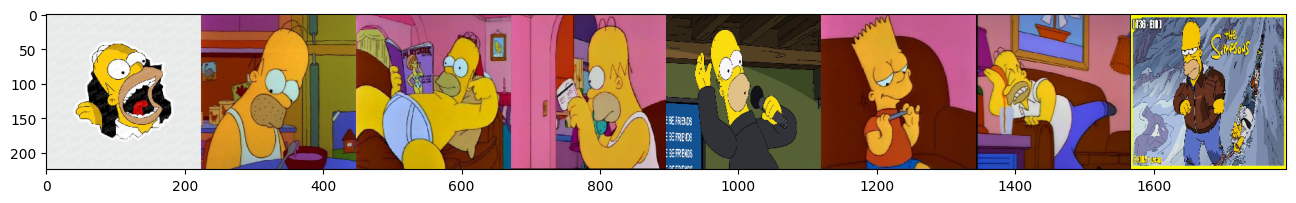

In [12]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg','.webp','.avif']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

In [13]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=20,
                    validation_data=(x_val, y_val))


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.4691 - loss: 0.7062 - val_accuracy: 0.5294 - val_loss: 0.6815
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.4938 - loss: 0.7245 - val_accuracy: 0.4706 - val_loss: 0.7381
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.4938 - loss: 0.7642 - val_accuracy: 0.4706 - val_loss: 0.7015
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5062 - loss: 0.6847 - val_accuracy: 0.4118 - val_loss: 0.6880
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.7654 - loss: 0.6602 - val_accuracy: 0.5294 - val_loss: 0.6856
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.6049 - loss: 0.6613 - val_accuracy: 0.5294 - val_loss: 0.6819
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.5926 - loss: 0.6481 - val_accuracy: 0.5294 - val_loss: 0.6765
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.7778 - loss: 0.6228 - val_accuracy: 0.5882 - val_loss: 

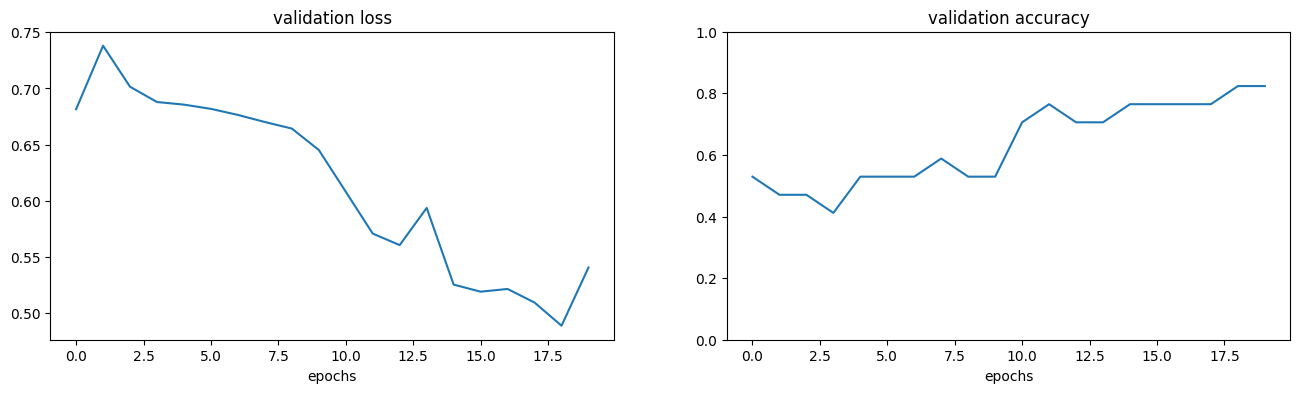

In [15]:
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"], label="val_loss")
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"], label="val_accuracy")
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()


In [16]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6200505495071411
Test accuracy: 0.7222222089767456


In [ ]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

241115136/553467096 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step

In [ ]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


In [ ]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

In [ ]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=20,
                         validation_data=(x_val, y_val))


In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

In [ ]:
img, x = get_image('/content/DIO-LLMs/Images/Bart/19.jpg')
probabilities = model_new.predict(x)
predicted_index = np.argmax(probabilities)
predicted_class = os.path.basename(categories[predicted_index])
confidence = probabilities[0][predicted_index] * 100

plt.imshow(img)
plt.title(f"Classe prevista: {predicted_class} ({confidence:.2f}%)")
plt.axis('off')
plt.show()